In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats.qmc import LatinHypercube
from scipy.stats import uniform, loguniform, norm, gaussian_kde
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D
import itertools  # Import the itertools module
import GPy
from scipy.spatial import ConvexHull, Voronoi
from datetime import datetime

# Guide and Ideas for Capstone Project - Function 5

# Function 5: Yield in a Chemical Reaction
This time you are trying to optimise another four-dimensional black-box. It corresponds to the yield of a chemical process after processing in some factory. This type of process tends to be unimodal. Try to find the combination of chemicals that maximizes the yield!

We begin this guide by downloading the data:

In [2]:
X = np.load('initial_data/function_5/initial_inputs.npy')
Y = np.load('initial_data/function_5/initial_outputs.npy')
print(X)
print(Y)

[[0.19144708 0.03819337 0.60741781 0.41458414]
 [0.75865295 0.53651774 0.65600038 0.36034155]
 [0.43834987 0.8043397  0.21024527 0.15129482]
 [0.70605083 0.53419196 0.26424335 0.48208755]
 [0.83647799 0.19360965 0.6638927  0.78564888]
 [0.68343225 0.11866264 0.82904591 0.56757661]
 [0.55362148 0.66734998 0.32380582 0.81486975]
 [0.35235627 0.32224153 0.11697937 0.47311252]
 [0.15378571 0.72938169 0.42259844 0.44307417]
 [0.46344227 0.63002451 0.10790646 0.9576439 ]
 [0.67749115 0.35850951 0.47959222 0.07288048]
 [0.58397341 0.14724265 0.34809746 0.42861465]
 [0.30688872 0.31687813 0.62263448 0.09539906]
 [0.51114177 0.817957   0.72871042 0.11235362]
 [0.43893338 0.77409176 0.37816709 0.93369621]
 [0.22418902 0.84648049 0.87948418 0.87851568]
 [0.72526172 0.47987049 0.08894684 0.75976022]
 [0.35548161 0.63961937 0.41761768 0.12260384]
 [0.11987923 0.86254031 0.64333133 0.84980383]
 [0.12688467 0.15342962 0.77016219 0.19051811]]
[6.44434399e+01 1.83013796e+01 1.12939795e-01 4.21089813e+0

In [3]:
def format_query(point, NoOfDigits):
    return '-'.join(f"{x:.{NoOfDigits}f}" for x in point)

In [4]:
def print_timestamp():
    # Print out the timestamp
    print("Current Timestamp: ", datetime.now())

In [5]:
# Print X with 16 digits of precision
for row in X:
    print(format_query(row,16))

# Print a separator line
print("-" * 50)

# Print Y with 16 digits of precision
print(format_query(Y,16))

0.1914470844571281-0.0381933713515080-0.6074178108720669-0.4145841369758819
0.7586529492430261-0.5365177380716337-0.6560003817255494-0.3603415530292176
0.4383498726531088-0.8043397048222797-0.2102452663986997-0.1512948160943209
0.7060508340594309-0.5341919611519633-0.2642433451718953-0.4820875490370939
0.8364779930351233-0.1936096468617801-0.6638926969585176-0.7856488828898288
0.6834322498676915-0.1186626417884907-0.8290459096967396-0.5675766059352313
0.5536214795168241-0.6673499787364745-0.3238058191550842-0.8148697537245304
0.3523562694659523-0.3222415319718314-0.1169793675885732-0.4731125215557709
0.1537857059438135-0.7293816904129607-0.4225984366784806-0.4430741656488165
0.4634422673852829-0.6300245101467290-0.1079064558186504-0.9576438986701130
0.6774911484129013-0.3585095065455117-0.4795922244652951-0.0728804811001408
0.5839734124984879-0.1472426461525712-0.3480974620935275-0.4286146510285499
0.3068887187315784-0.3168781265532129-0.6226344812966896-0.0953990581063173
0.5111417749

In [6]:
# load w1 data
pd_new = pd.read_csv("data/capstone_results.csv")
print(pd_new.head(10))

   Week  Student  Fn        X1        X2        X3        X4        X5  \
0     1      427   1  0.605439  0.664755       NaN       NaN       NaN   
1     1      427   2  0.929767  0.997474       NaN       NaN       NaN   
2     1      427   3  0.990000  0.990000  0.000000       NaN       NaN   
3     1      427   4  0.459180  0.459289  0.399209  0.408363       NaN   
4     1      427   5  0.261839  0.845899  0.945459  0.906905       NaN   
5     1      427   6  0.464312  0.339986  0.491438  0.749695  0.159201   
6     1      427   7  0.000000  0.268289  0.446722  0.095962  0.273324   
7     1      427   8  0.088905  0.288209  0.044306  0.256810  0.634647   
8     1      428   1  0.628540  0.628540       NaN       NaN       NaN   
9     1      428   2  0.983984  0.999998       NaN       NaN       NaN   

         X6        X7       X8            Y  
0       NaN       NaN      NaN     0.007671  
1       NaN       NaN      NaN    -0.011315  
2       NaN       NaN      NaN    -0.146375  
3

In [7]:
## need to change the function name

pw_fn = pd_new[pd_new['Fn']==5]
# Extract X1 and X2 into a 2D array and Y into a 1D array
# Here we're ensuring to drop any NaN values as they can't be used in most models.
X_new_points = pw_fn[['X1','X2','X3','X4']].dropna().values
Y_new_points = pw_fn['Y'].dropna().values
print(X_new_points)
print(Y_new_points)

[[0.261839 0.845899 0.945459 0.906905]
 [0.310345 0.827586 0.965517 0.931034]
 [0.120775 0.158811 0.080574 0.643568]
 [0.263158 0.842105 0.894737 0.894737]
 [0.223328 0.835221 0.899041 0.888129]
 [0.002282 0.103012 0.012698 0.015942]
 [0.25     0.875    0.875    0.875   ]
 [0.322581 0.822222 0.980808 0.935484]
 [0.5      0.5      0.5      0.5     ]
 [0.       0.473684 0.736842 0.9999  ]
 [0.29372  0.8323   0.967791 0.928197]
 [0.292948 0.320623 0.       0.785236]
 [0.325    0.325    0.325    0.325   ]
 [0.999999 0.999999 0.999999 0.999999]
 [0.687627 0.964368 0.901467 0.570893]
 [0.744219 0.668769 0.787038 0.825263]
 [0.999881 0.99972  0.999867 0.999505]
 [0.95     0.95     0.5      0.7     ]
 [0.75     0.75     0.75     0.75    ]]
[1.63046850e+03 1.86335602e+03 6.34882159e+01 1.23108763e+03
 1.18509255e+03 1.62863376e+02 1.18206863e+03 2.00166331e+03
 3.20025000e+01 5.36197326e+02 1.88113761e+03 3.68281988e+00
 1.28535175e+02 8.66240500e+03 1.35998647e+03 5.71363636e+02
 8.64260623e+0

In [8]:
#append w1 data to the end

X_updated = np.vstack((X, X_new_points))
Y_updated = np.append(Y, Y_new_points)
print(X_updated)
print(Y_updated)

[[0.19144708 0.03819337 0.60741781 0.41458414]
 [0.75865295 0.53651774 0.65600038 0.36034155]
 [0.43834987 0.8043397  0.21024527 0.15129482]
 [0.70605083 0.53419196 0.26424335 0.48208755]
 [0.83647799 0.19360965 0.6638927  0.78564888]
 [0.68343225 0.11866264 0.82904591 0.56757661]
 [0.55362148 0.66734998 0.32380582 0.81486975]
 [0.35235627 0.32224153 0.11697937 0.47311252]
 [0.15378571 0.72938169 0.42259844 0.44307417]
 [0.46344227 0.63002451 0.10790646 0.9576439 ]
 [0.67749115 0.35850951 0.47959222 0.07288048]
 [0.58397341 0.14724265 0.34809746 0.42861465]
 [0.30688872 0.31687813 0.62263448 0.09539906]
 [0.51114177 0.817957   0.72871042 0.11235362]
 [0.43893338 0.77409176 0.37816709 0.93369621]
 [0.22418902 0.84648049 0.87948418 0.87851568]
 [0.72526172 0.47987049 0.08894684 0.75976022]
 [0.35548161 0.63961937 0.41761768 0.12260384]
 [0.11987923 0.86254031 0.64333133 0.84980383]
 [0.12688467 0.15342962 0.77016219 0.19051811]
 [0.261839   0.845899   0.945459   0.906905  ]
 [0.310345   

## Random Search

The simplest solution would be a simple random search, that is, we can randomly choose our next query point:

In [9]:
next_query = np.random.uniform(size = 4)
print(next_query)

[0.26385456 0.83382566 0.6262414  0.48871841]


While this solution is easy to implement, we know it will be very slow. However, it could serve as a placeholder for gathering more information while you research which method you want to use for each function.

## Visualizing our data and thinking of the problem

Analysis of Initial Dataset: The initial dataset provided gives a starting point. Analyzing this data using statistical techniques or visualization might provide insights into the behavior of the functions and where to search next.

what we know about the problem:

1.From the hints, expect a lot of local optima.

In [10]:
# Convert to DataFrame for easier handling
df = pd.DataFrame(X_updated, columns=['x1', 'x2', 'x3', 'x4'])
df['output'] = Y_updated

In [11]:
# Statistical Summary
print("Statistical Summary:")
print(df.describe())


Statistical Summary:
              x1         x2         x3         x4       output
count  39.000000  39.000000  39.000000  39.000000    39.000000
mean    0.448858   0.591422   0.581557   0.624851   926.621472
std     0.273709   0.292635   0.315580   0.312102  1925.633319
min     0.000000   0.038193   0.000000   0.015942     0.112940
25%     0.255919   0.323621   0.336549   0.421599    51.376554
50%     0.355482   0.667350   0.643331   0.750000   162.863376
75%     0.685530   0.833761   0.877242   0.891433  1183.580591
max     0.999999   0.999999   0.999999   0.999999  8662.405001


[7.42649862e-03 2.09972599e-03 0.00000000e+00 4.73080139e-04
 2.98140012e-02 9.04165416e-03 6.63318631e-03 1.26362555e-02
 1.00839961e-03 2.69109687e-02 2.80643372e-03 7.42380961e-03
 7.31489721e-03 9.19112281e-03 4.10623280e-02 1.25688059e-01
 3.31942304e-03 5.20285281e-03 4.98135844e-02 1.13819668e-03
 1.88212952e-01 2.15098159e-01 7.31622482e-03 1.42107271e-01
 1.36797467e-01 1.87883801e-02 1.36448377e-01 2.31064753e-01
 3.68142288e-03 6.18871290e-02 2.17150918e-01 4.12117261e-04
 1.48254335e-02 1.00000000e+00 1.56987725e-01 6.59468293e-02
 9.97714373e-01 1.74097044e-01 5.38529014e-02]


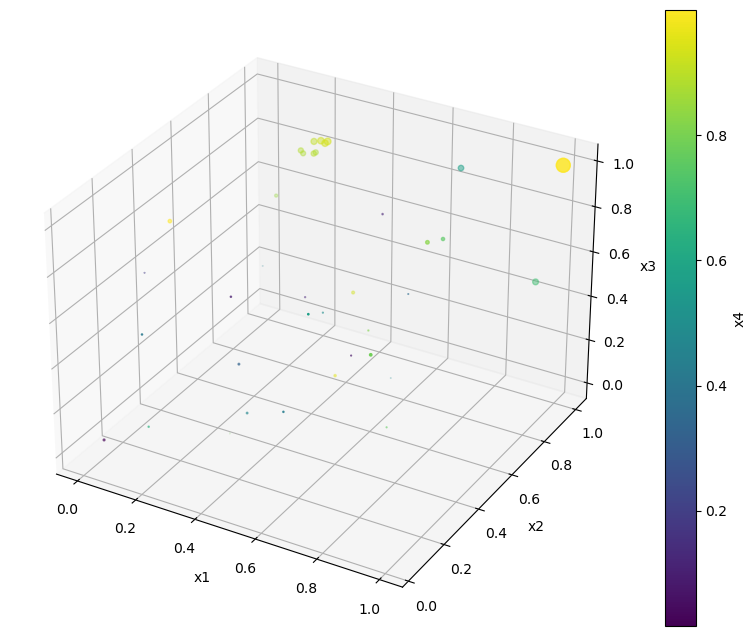

In [12]:
# Normalize Y for better visualization
Y_norm = (Y_updated - Y_updated.min()) / (Y_updated.max() - Y_updated.min())
print(Y_norm)

# Size scaling factor - you can adjust this
size_scale = 100 

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use color for the fourth dimension and size for the fifth dimension
sc = ax.scatter(X_updated[:, 0], X_updated[:, 1], X_updated[:, 2], c=X_updated[:, 3], cmap='viridis', s=Y_norm * size_scale)

# Create colorbar
cbar = plt.colorbar(sc)
cbar.set_label('x4')

# Set labels for axes
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')

# Show plot
plt.show()

## Maximum Empty Circle or MEC in a Voronoi diagram (Convex)

In [13]:

# Replace with the 4D points
# Example: points = np.random.rand(10, 4)
points = X_updated  # 4D dataset

# Creating the Voronoi diagram for 4D points
vor = Voronoi(points)

# Compute Convex Hull in 4D
hull = ConvexHull(points)

# Function to check if a point is inside the convex hull
def in_hull(p, hull):
    return all((np.dot(eq[:-1], p) + eq[-1] <= 0) for eq in hull.equations)

# Find the largest empty sphere in 4D
max_radius = 0
center_of_max_sphere = None

for vertex in vor.vertices:
    if in_hull(vertex, hull):
        min_distance_to_point = min(np.linalg.norm(vertex - point) for point in points)
        if min_distance_to_point > max_radius:
            max_radius = min_distance_to_point
            center_of_max_sphere = vertex

# Visualization is not feasible directly in 4D
# You can print the results or analyze them programmatically
if center_of_max_sphere is not None:
    print(f"Center of the largest empty sphere: {format_query(center_of_max_sphere,6)}")
    print("Radius of the largest empty sphere:", max_radius)
else:
    print("No empty sphere found within the convex hull.")
    
print_timestamp()    

Center of the largest empty sphere: 0.131255-0.446204-0.776203-0.554289
Radius of the largest empty sphere: 0.46701365037814924
Current Timestamp:  2024-02-03 16:11:22.925485


## Maximum Empty Circle or MEC in a Voronoi diagram

In [14]:

def largest_empty_circle(points):
    # Compute Voronoi diagram
    vor = Voronoi(points)
    
    # Iterate over Voronoi regions
    max_radius = 0
    best_point = None
    for point, region in zip(vor.points, vor.regions):
        if not region or -1 in region:
            continue

        # Compute the distances from the point to all edges of its Voronoi region
        region_points = np.asarray([vor.vertices[i] for i in region])
        distances = np.sqrt(((region_points - point) ** 2).sum(axis=1))

        # Find the maximum distance
        min_distance = np.min(distances)
        if min_distance > max_radius:
            max_radius = min_distance
            best_point = point

    return best_point, max_radius

# dataset points
points = X_updated
center, radius = largest_empty_circle(points)


if center is not None:
    print("Center of the largest empty circle:", format_query(center,6))
    print("Radius of the largest empty circle:", radius)
else:
    print("No empty circle found.")
    
print_timestamp()

Center of the largest empty circle: 0.224189-0.846480-0.879484-0.878516
Radius of the largest empty circle: 0.6722496909887424
Current Timestamp:  2024-02-03 16:11:23.403818


## The best point is [0.999999, 0.999999, 0.999999, 0.999999]


In [15]:
# updated 4D dataset
points = X_updated

# Fit KDE to data
data_kde = gaussian_kde(points.T)

# Best point coordinates for 4D
best_points = [0.999999, 0.999999, 0.999999, 0.999999]  

# Define the threshold for each dimension
threshold = 0.2  # Example threshold value

# Calculate min and max values for each dimension based on the threshold
min_values = [x - threshold for x in best_points]
max_values = [x + threshold for x in best_points]

# Increase the number of samples significantly
num_samples = 100000  # Larger number of samples

# Sample new points from the KDE
kde_samples = data_kde.resample(size=num_samples)

# Filter the samples to only keep those within the defined region
conditions = [(kde_samples[i] >= min_values[i]) & (kde_samples[i] <= max_values[i]) for i in range(len(best_points))]
conditions += [(kde_samples[i] >= 0) & (kde_samples[i] <= 1) for i in range(len(best_points))]  # Ensure all dimensions are within [0, 1]
kde_samples_filtered = kde_samples[:, np.all(conditions, axis=0)].T

# Check if we have any points after filtering
if kde_samples_filtered.size == 0:
    raise ValueError("No points sampled within the specified region.")

# The target point in 4D
target_point = np.array(best_points)

# Compute the Euclidean distances from each point in the dataset to the target point
distances = np.linalg.norm(kde_samples_filtered - target_point, axis=1)

# Get the indices of the 10 closest points
closest_indices = np.argsort(distances)[:10]

# Retrieve the closest points using these indices
closest_points = kde_samples_filtered[closest_indices]

print("The 10 closest points to", best_points, "are:")
print(closest_points)
print_timestamp()

The 10 closest points to [0.999999, 0.999999, 0.999999, 0.999999] are:
[[0.97096712 0.96157904 0.97440154 0.9774877 ]
 [0.98100958 0.93369211 0.97724168 0.97573635]
 [0.94818101 0.96110392 0.95834303 0.98196391]
 [0.93460519 0.98136867 0.95048733 0.99624775]
 [0.93732115 0.95262907 0.94991472 0.99758865]
 [0.99614259 0.9577149  0.92007731 0.97628103]
 [0.99064036 0.9596974  0.91906613 0.9725018 ]
 [0.97866708 0.93789531 0.96606059 0.93844446]
 [0.98645447 0.99092663 0.94670758 0.92050791]
 [0.98674469 0.94564381 0.94290283 0.92964276]]
Current Timestamp:  2024-02-03 16:11:25.495453


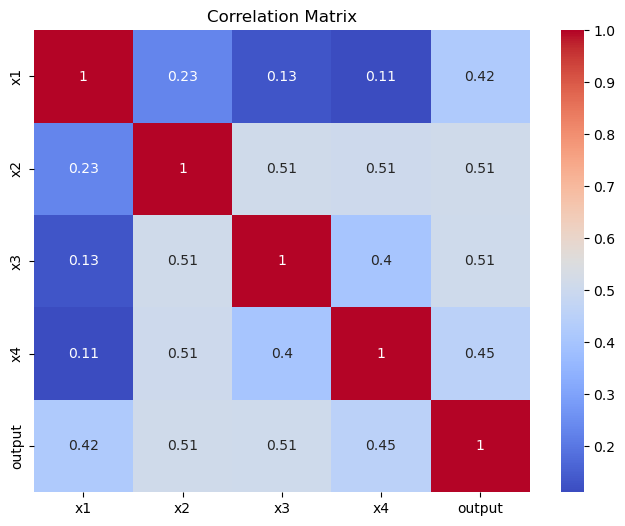

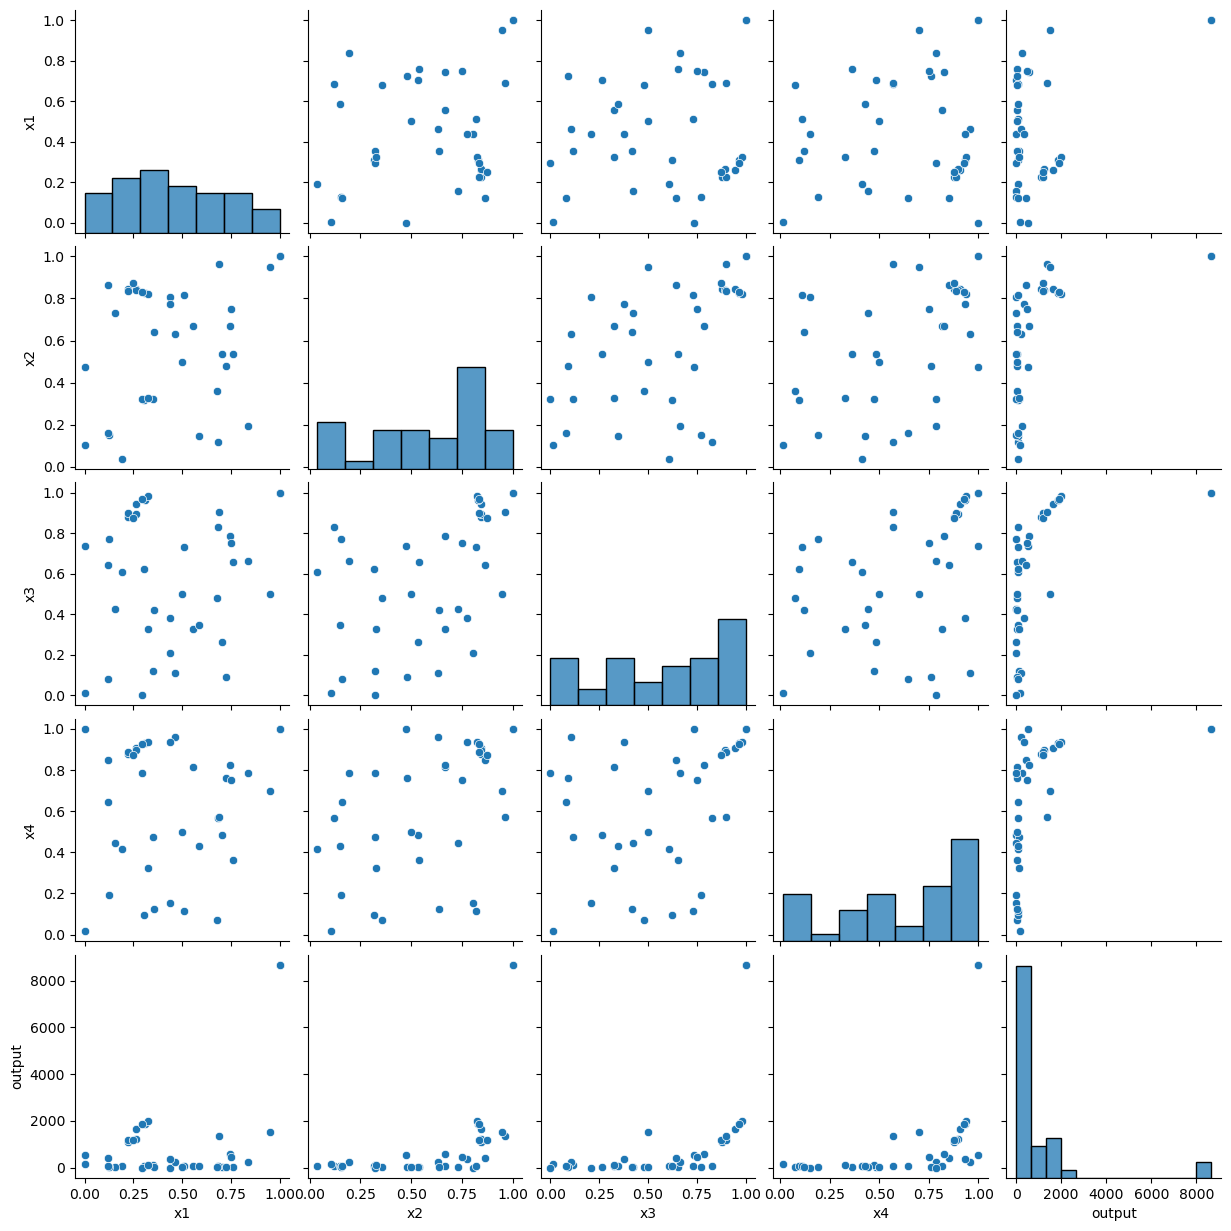

In [16]:
# Calculate correlations
correlations = df.corr()

# Plotting the correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pairplot to visualize relationships
sns.pairplot(df)
plt.show()

In [16]:
def compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi):
    """
    Compute kappa and xi values for each week in an optimization loop.

    Parameters:
    N_WEEKS: Number of weeks for the optimization loop.
    kappa_initial: Initial value of kappa.
    kappa_decay: Decay rate of kappa per week.
    min_kappa: Minimum value of kappa.
    xi_initial: Initial value of xi.
    xi_decay: Decay rate of xi per week.
    min_xi: Minimum value of xi.

    Returns:
    kappa_array: Array of kappa values for each week.
    xi_array: Array of xi values for each week.
    """

    kappa_array = np.zeros(N_WEEKS)
    xi_array = np.zeros(N_WEEKS)

    for week in range(N_WEEKS):
        kappa = max(kappa_initial * (kappa_decay ** week), min_kappa)
        xi = max(xi_initial * (xi_decay ** week), min_xi)
        kappa_array[week] = kappa
        xi_array[week] = xi

    return kappa_array, xi_array

# Example usage:
N_WEEKS = 10
kappa_initial = 1.96
kappa_decay = 0.9
min_kappa = 0.1
xi_initial = 0.1
xi_decay = 0.9
min_xi = 0.01

kappa_array, xi_array = compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi)
print("Kappa Array:", kappa_array)
print("Xi Array:", xi_array)

Kappa Array: [1.96       1.764      1.5876     1.42884    1.285956   1.1573604
 1.04162436 0.93746192 0.84371573 0.75934416]
Xi Array: [0.1        0.09       0.081      0.0729     0.06561    0.059049
 0.0531441  0.04782969 0.04304672 0.03874205]


In [17]:
#Evaluate Model Performance

def evaluate_model_performance(model, X_test, Y_test, model_type='sklearn'):
    """
    Evaluate the performance of a Gaussian Process model.

    Parameters:
    model: The trained Gaussian Process model.
    X_test: Test data features (numpy array).
    Y_test: True values for test data (numpy array).

    Returns:
    mse: Mean Squared Error of the model on the test data.
    r2: R-squared value indicating the proportion of variance explained by the model.
    """

    if model_type == 'gpy':
        y_pred, var_pred = model.predict(X_test)
        std_pred = np.sqrt(var_pred)
    elif model_type == 'sklearn':
        y_pred, std_pred = model.predict(X_test, return_std=True)

    # Ensure y_pred is 1D
    y_pred = y_pred.flatten()

    # Calculate residuals
    residuals = Y_test.flatten() - y_pred

    # Check if dimensions match
    if y_pred.shape != residuals.shape:
        raise ValueError(f"Shape mismatch: y_pred shape {y_pred.shape} and residuals shape {residuals.shape} must be the same.")        
        
    # Calculate MSE and R-squared
    mse = mean_squared_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    
    print(f"MSE: {mse}")
    print(f"R-squared: {r2}")

    # Analyze residuals
    residuals = Y_test - y_pred

    # Plot residuals to look for patterns
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

    return mse, r2

# Usage example:
# mse, r2 = evaluate_model_performance(best_gp, X_w1_new_points, Y_w1_new_points)
# print(f"MSE: {mse}")
# print(f"R-squared: {r2}")

In [18]:
# define multiple acquisition functions

#an acquisition function used in Bayesian optimization. 
# The EI is calculated for a set of points X, given a Gaussian process gp. It's used to determine the next point to sample.
def expected_improvement(X_grid, gp, xi=0.01, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
        mu_sample_opt = np.max(gp.predict(gp.X))
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X, return_std=True)
        mu_sample_opt = np.max(gp.predict(gp.X_train_, return_std=False))

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei


# Probability of Improvement acquisition function
def probability_of_improvement(X_grid, gp, xi=0.01, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
        mu_sample_opt = np.max(gp.predict(gp.X))
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X_grid, return_std=True)
        mu_sample_opt = np.max(gp.predict(gp.X_train_, return_std=False))

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        pi = norm.cdf(Z)
        pi[sigma == 0.0] = 0.0

    return pi


# Define the UCB acquisition function
# After optimizing the hyperparameters, the Upper Confidence Bound (UCB) is used as the acquisition function in the weekly optimization loop. 
# The UCB balances exploration (trying new, uncertain points) and exploitation (focusing on points known to yield good results).
def upper_confidence_bound(X_grid, gp, kappa=1.96, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X_grid, return_std=True)

    return mu + kappa * sigma

In [19]:
# define grid based on dimensions

def generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points):
    """
    Generate a 2D grid of points for optimization.

    Parameters:
    domain_start_x1: Starting value of the first dimension.
    domain_end_x1: Ending value of the first dimension.
    domain_start_x2: Starting value of the second dimension.
    domain_end_x2: Ending value of the second dimension.
    num_points: Number of points to generate in each dimension.

    Returns:
    X_grid: A 2D numpy array of grid points.
    """

    # Generate arrays of evenly spaced values in each dimension
    x1 = np.linspace(domain_start_x1, domain_end_x1, num_points)
    x2 = np.linspace(domain_start_x2, domain_end_x2, num_points)

    # Use numpy's meshgrid function to create a grid efficiently
    X_grid = np.array(np.meshgrid(x1, x2)).T.reshape(-1, 2)

    return X_grid
# Example usage:
# domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2 = 0.6, 0.65, 0.6, 0.65
# num_points = 100
# X_grid = generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points)

def generate_nd_grid(max_points, dimensions):
    # define range for input
	r_min, r_max = 0, 1.0

	# generate a random sample from the domain (dimensions)
	nd_grid = r_min + np.random.rand(max_points, dimensions) * (r_max - r_min)
	
	return np.array(nd_grid)

In [20]:
# propose the next points for all three acquisition functions

def propose_next_point(xi, kappa, X_grid, best_gp, model_type = 'sklearn'):
    """
    Update exploration-exploitation parameters and calculating next query points.
   
    Returns:
    Next query points for EI, PI, and UCB.
    """


    # EI next point calculation
    ei_values = expected_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_ei = np.argmax(ei_values)
    next_point_ei = X_grid[next_point_index_ei]
    print('Next query EI: ', format_query(next_point_ei, 6))

    # PI next point calculation
    pi_values = probability_of_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_pi = np.argmax(pi_values)
    next_point_pi = X_grid[next_point_index_pi]
    print('Next query PI: ', format_query(next_point_pi, 6))

    # UCB next point calculation
    ucb_value = upper_confidence_bound(X_grid, best_gp, kappa,model_type)
    next_point_index_ucb = np.argmax(ucb_value)
    next_point_ucb = X_grid[next_point_index_ucb]
    print('Next query UCB: ', format_query(next_point_ucb, 6))

    return next_point_ei, next_point_pi, next_point_ucb

# Approach 2: Surrogate - using sklearn GP model train accumulatively

In [44]:
from sklearn.preprocessing import StandardScaler
from scipy.optimize import fmin_l_bfgs_b
#Approach 2 - modified
#Randomized Hyperparameter Search: 
#defines a search space for the kernel parameters, creates a Gaussian process model, and then uses RandomizedSearchCV to find the best hyperparameters based on cross-validation. 
# The best model and parameters are then displayed.

# Since X is already scaled between 0 and 1, we only scale Y
#Y_scaler = StandardScaler()
#Y_scaled = Y_scaler.fit_transform(Y_updated.reshape(-1, 1)).ravel()

param_distributions = {
    'kernel__k1__constant_value': loguniform(1e-2, 1e6),
    'kernel__k2__length_scale': loguniform(1e-2, 10)
    #'k2__noise_level': loguniform(1e-3, 1e1)
}

kernel = C(1.0, (1e-2, 1e6)) * RBF(1.0, (1e-2, 10))  

# Define a custom optimizer function with more iterations
def custom_optimizer(obj_func, initial_theta, bounds):
    theta_opt, func_min, _ = fmin_l_bfgs_b(obj_func, initial_theta, bounds=bounds, maxfun=20000, factr=10.0)
    return theta_opt, func_min


# Create the Gaussian Process Regressor with increased optimizer iterations
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, optimizer=custom_optimizer, 
                              normalize_y=True, alpha=1e-10)

# Setup the randomized search with more iterations
random_search = RandomizedSearchCV(gp, param_distributions, n_iter=100, cv=5, random_state=42, n_jobs=-1)

#random_search.fit(X_updated,Y_scaled)
random_search.fit(X_updated,Y_updated)


best_gp = random_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

print_timestamp()

Best Parameters: {'kernel__k1__constant_value': 607.0155694141799, 'kernel__k2__length_scale': 5.829384542994737}
Log-marginal-likelihood: -19.502412529481795
Current Timestamp:  2024-02-03 17:40:41.659180


## Appoach 2: using sklearn GP model via random generated grid

Next query EI:  0.289364-0.636401-0.912497-0.782740
Next query PI:  0.988529-0.009420-0.004082-0.021173
Next query UCB:  0.998086-0.982965-0.942506-0.999880
MSE: 9083139.299699023
R-squared: -0.5004214419099011


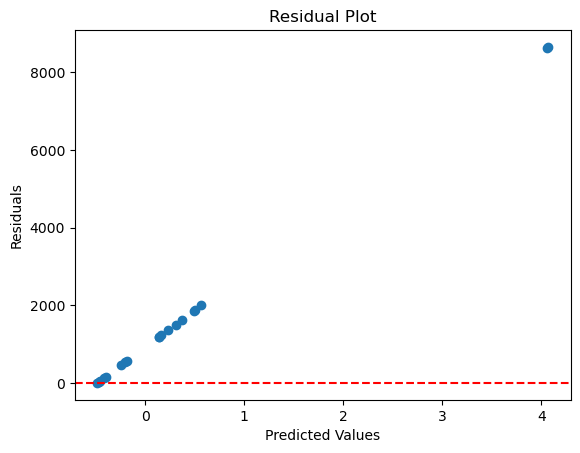

Current Timestamp:  2024-02-03 17:17:23.018801


In [37]:
#Approach 2: using sklearn GP model

# generate grid
max_points = 7000000 #9,000,000 (too big for memory)
dimensions = 4  # Change this to the desired number of dimensions
X_grid = []
X_grid = generate_nd_grid(max_points, dimensions)


# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 3  # For week 4, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid,best_gp,'sklearn')

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

print_timestamp()

## Appoach 2: using sklearn GP model via Voronoi diagram generated grid

Next query EI:  0.883604-0.928042-0.979138-0.978120
Next query PI:  0.952592-0.987407-0.829175-0.995370
Next query UCB:  0.934605-0.981369-0.950487-0.996248
MSE: 9083139.299699023
R-squared: -0.5004214419099011


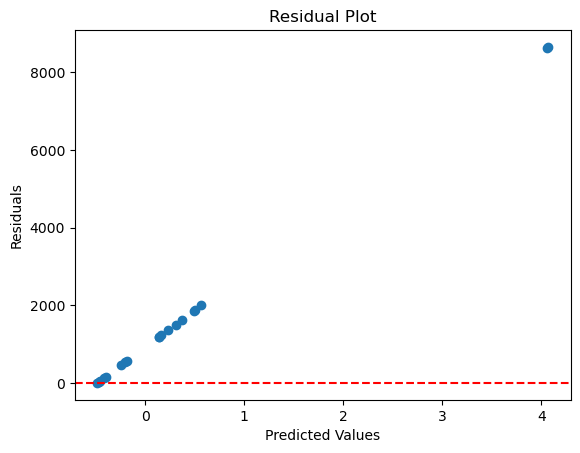

Current Timestamp:  2024-02-03 17:17:37.888309


In [38]:
# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 3  # For week 4, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,kde_samples_filtered,best_gp,'sklearn')

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

print_timestamp()

In [43]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_
mse = mean_squared_error(Y_new_points, best_rf.predict(X_new_points))
r2 = r2_score(Y_new_points, best_rf.predict(X_new_points))

print("Tuned Random Forest MSE:", mse)
print("Tuned Random Forest R-squared:", r2)



Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Random Forest MSE: 7476836.267939898
Tuned Random Forest R-squared: -0.23508019462371954


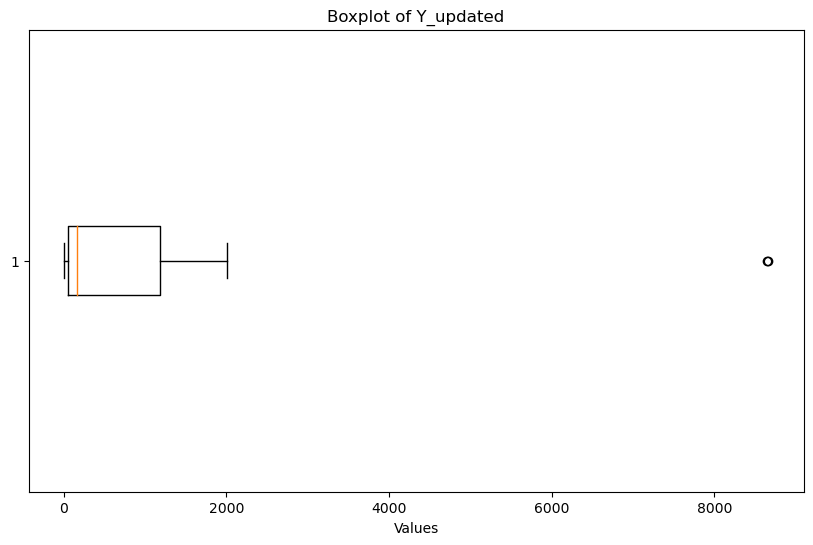

Outliers using Z-score method: [33 36]
Outliers using IQR method: [33 36]


In [19]:
# Function to identify outliers using Z-score
def find_outliers_z_score(data):
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    z_scores = [(y - mean) / std for y in data]
    return np.where(np.abs(z_scores) > threshold)

# Function to identify outliers using IQR
def find_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.where((data < lower_bound) | (data > upper_bound))

# Apply the outlier detection methods on Y
outliers_z_score = find_outliers_z_score(Y_updated)
outliers_iqr = find_outliers_iqr(Y_updated)

# Plotting boxplot for visual inspection
plt.figure(figsize=(10, 6))
plt.boxplot(Y_updated, vert=False)
plt.title("Boxplot of Y_updated")
plt.xlabel("Values")
plt.show()

# Print the indices of the outliers
print("Outliers using Z-score method:", outliers_z_score[0])
print("Outliers using IQR method:", outliers_iqr[0])

## Aproach 3:  a Sparse Gaussian Process model

In [39]:
# Approach 3: gpy GP model

# Assuming X_w1 and Y_w1 are your data points
# Ensure X_w1 and Y_w1 are correctly shaped
# X_w1 = ... (your data, should be 2D, e.g., [n_samples, n_features])
# Y_w1 = ... (your data, should be 2D, e.g., [n_samples, 1])

# If Y is 1D, convert it to 2D
if Y_scaled.ndim == 1:
    Y_scaled_2d = Y_scaled[:, np.newaxis]

# Create a kernel with RBF
kernel = GPy.kern.RBF(input_dim=X_updated.shape[1], variance=1., lengthscale=1.)

# Number of inducing points - this can be tuned based on your problem
num_inducing = 10  # This is an example value

# Creating a Sparse Gaussian Process Model
gp_sparse = GPy.models.SparseGPRegression(X_updated, Y_scaled_2d, kernel, num_inducing=num_inducing)

# Model Optimization
gp_sparse.optimize(messages=True, optimizer='lbfgsb', max_iters=1000)

# Optionally, you can constrain parameters to be positive
gp_sparse.constrain_positive()

# After optimization, you can check the optimized hyperparameters
print("Optimized kernel parameters:", gp_sparse.kern)
print("Optimized noise variance:", gp_sparse.Gaussian_noise.variance)

# Evaluate model performance on a validation set, X_val and Y_val
Y_pred, Y_var = gp_sparse.predict(X_new_points)
mse = np.mean((Y_new_points - Y_pred)**2)
print("MSE on validation set:", mse)

reconstraining parameters sparse_gp


Optimized kernel parameters:   rbf.         |               value  |  constraints  |  priors
  variance     |  3.1012977666498713  |      +ve      |        
  lengthscale  |  0.9369675735593046  |      +ve      |        
Optimized noise variance:   index  |  sparse_gp.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                         0.09608078  |      +ve      |        
MSE on validation set: 9089439.386928875


##

Next query EI:  0.990508-0.984695-0.996690-0.993750
Next query PI:  0.990508-0.984695-0.996690-0.993750
Next query UCB:  0.990508-0.984695-0.996690-0.993750
MSE: 9083902.349388873
R-squared: -0.5005474882115282


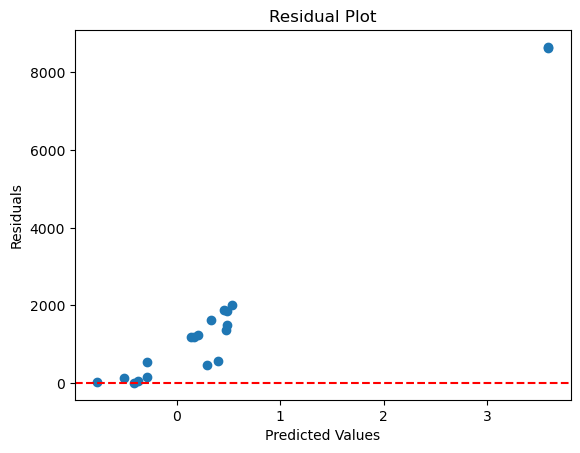

Current Timestamp:  2024-02-03 17:19:31.204800


In [40]:
# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid, gp_sparse,'gpy')

mse, r2 = evaluate_model_performance(gp_sparse, X_new_points, Y_new_points,'gpy')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

print_timestamp()